In [14]:
import pandas as pd
import numpy as np
import pyclustertend 
import random
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.metrics import silhouette_samples, silhouette_score
import sklearn.preprocessing
from sklearn.datasets import make_classification
from sklearn.cluster import Birch, KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib.cm as cm
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

### Pregunta 1

In [66]:
movies = pd.read_csv('movies.csv', encoding = "ISO-8859-1")
graph_labels = []
group_by = 'genre'
columns = list(movies.describe().columns[1:])
columns.append('actorsPopularity')
columns.append('castWomenAmount')
columns.append('castMenAmount')
columns.append('popular')

popular = []
genres = []
temp = movies
for index, row in temp.iterrows():
  try:

    data = row['actorsPopularity'].split('|')
    value = np.sort(np.array(data).astype(float))[-1]

    # Aqui se observa si los datos tienen sentido
    if (
      row['budget'] >= 300000000 or 
      row['revenue'] >= 1200000000 or
      row['runtime'] >= 300 or
      row['popularity'] >= 900 or
      row['voteCount'] >= 20000 or
      row['genresAmount'] >= 10 or
      row['productionCoAmount'] >= 25 or
      row['productionCountriesAmount'] >= 20 or
      row['actorsAmount'] >= 200 or
      int(row['castWomenAmount']) >= 55 or
      int(row['castMenAmount']) >= 100
    ):
      temp = temp.drop(index=index)
      continue
    genres.append(row['genres'].split('|')[0])
    popular.append(value)
  except:
    temp = temp.drop(index=index)
temp['popular'] = popular
temp['genre'] = genres
temp = temp.drop('actorsPopularity', axis='columns')
columns.remove('actorsPopularity')
temp = temp.drop('genres', axis='columns')
temp = temp.astype({'castWomenAmount': int, 'castMenAmount': int})

# Aqui se hacen los grupos
# temp = temp.groupby(group_by)
# data = np.array(temp[columns])
# grouped_by = np.array(temp[[group_by]])

columns.remove('budget')
columns.remove('runtime')
variables = temp[columns]
normalized_variables = (variables-variables.min())/(variables.max()-variables.min())

graph_labels = [columns[0], columns[1]]

### Pregunta 2

In [67]:
random.seed(123)
X_scale=sklearn.preprocessing.scale(variables)

pyclustertend.hopkins(X_scale, len(X_scale))

0.07333077513511059

El valor de hopkins es de 0.085, por lo que vale la pena hacer el agrupamiento.

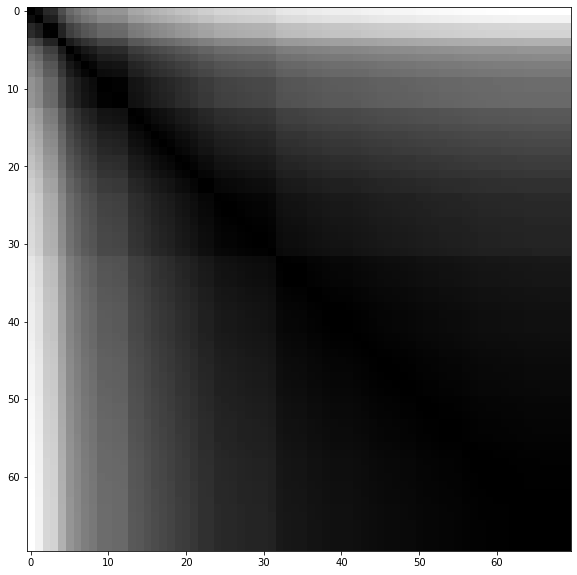

In [4]:
pyclustertend.vat(variables[:70])

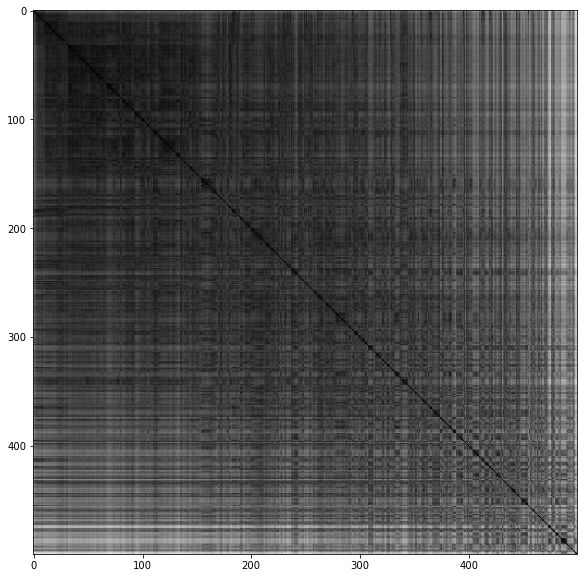

In [5]:
pyclustertend.vat(X_scale[:500])

### Pregunta 3

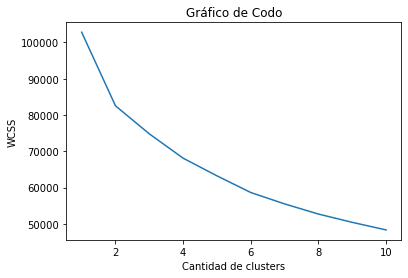

In [6]:
numeroClusters = range(1,11)

wcss = []
# Obtenemos 10 posibles clusters
for i in numeroClusters:
    # Se calcula la kmean con esa cantidad de clusters
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(X_scale)
    # Obtenemos la inercia
    wcss.append(kmeans.inertia_)

# Graficando
plt.plot(numeroClusters, wcss)
plt.xlabel("Cantidad de clusters")
plt.ylabel("WCSS")
plt.title("Gráfico de Codo")
plt.show()

In [7]:
number_clusters = 2

### Pregunta 4 - Metodo de K-Medias

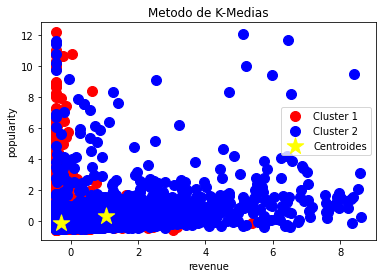

In [8]:
kmeans_cluster = KMeans(n_clusters=number_clusters)
kmeans_cluster.fit(X_scale)
kmeans_result = kmeans_cluster.predict(X_scale)

# Plot
plt.scatter(X_scale[kmeans_result == 0, 0], X_scale[kmeans_result == 0, 1], s = 100, c = 'red', label = "Cluster 1")
plt.scatter(X_scale[kmeans_result == 1, 0], X_scale[kmeans_result == 1, 1], s = 100, c = 'blue', label = "Cluster 2")
if number_clusters == 3: plt.scatter(X_scale[kmeans_result == 2, 0], X_scale[kmeans_result == 2, 1], s = 100, c = 'lime', label = "Cluster 3")
plt.scatter(kmeans_cluster.cluster_centers_[:,0], kmeans_cluster.cluster_centers_[:,1], s=300, c="yellow",marker="*", label="Centroides")
plt.title("Metodo de K-Medias")

plt.xlabel(graph_labels[0])
plt.ylabel(graph_labels[1])
plt.legend()
plt.show()

### Pregunta 4 - Metodo de BIRCH
Referencia de: https://www.freecodecamp.org/espanol/news/8-algoritmos-de-agrupacion-en-clusteres-en-el-aprendizaje-automatico-que-todos-los-cientificos-de-datos-deben-conocer/

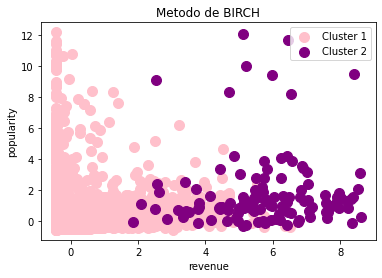

In [68]:
# Inicializar el modelo
birch_model = Birch(threshold=1.5, n_clusters=number_clusters)
birch_model.fit(X_scale)

# Obtenemos los puntos y los clusters
birch_result = birch_model.predict(X_scale)

# Graficar los clusters
plt.scatter(X_scale[birch_result == 0, 0], X_scale[birch_result == 0, 1], s = 100, c = 'pink', label = "Cluster 1")
plt.scatter(X_scale[birch_result == 1, 0], X_scale[birch_result == 1, 1], s = 100, c = 'purple', label = "Cluster 2")
if number_clusters == 3: plt.scatter(X_scale[birch_result == 2, 0], X_scale[birch_result == 2, 1], s = 100, c = 'skyblue', label = "Cluster 3")
plt.title("Metodo de BIRCH")
plt.xlabel(graph_labels[0])
plt.ylabel(graph_labels[1])
plt.legend()
plt.show()

### Pregunta 4 - Metodo de Agrupación Jerárquica  Aglomerativa

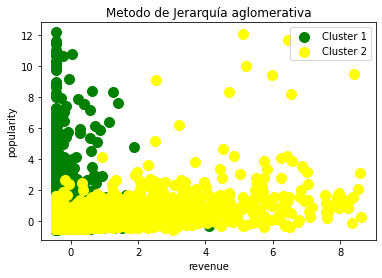

In [69]:
# Creación modelo y asignación de clusters = 2
agglomerative_model  = AgglomerativeClustering(n_clusters=number_clusters)
agglomerative_result = agglomerative_model.fit_predict(X_scale)

# Plotting
plt.scatter(X_scale[agglomerative_result == 0, 0], X_scale[agglomerative_result == 0, 1], s = 100, c = 'green', label = "Cluster 1")
plt.scatter(X_scale[agglomerative_result == 1, 0], X_scale[agglomerative_result == 1, 1], s = 100, c = 'yellow', label = "Cluster 2")
if number_clusters == 3: plt.scatter(X_scale[agglomerative_result == 2, 0], X_scale[agglomerative_result == 2, 1], s = 100, c = 'red', label = "Cluster 3")

# Set de gráfico
plt.title("Metodo de Jerarquía aglomerativa")
plt.xlabel(graph_labels[0])
plt.ylabel(graph_labels[1])
plt.legend()
plt.show()

#Ref: https://scikit-learn.org/

### Pregunta 4 - Metodo de MiniBatch

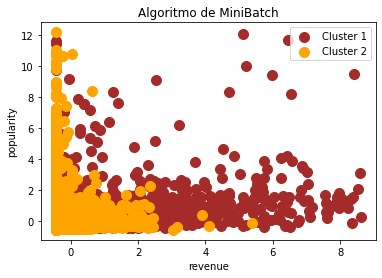

In [70]:
# Creación modelo y asignación de clusters = 2
minibatch_model = MiniBatchKMeans(n_clusters=number_clusters, batch_size=3072)
minibatch_result   = minibatch_model.fit_predict(X_scale)

# Plotting
plt.scatter(X_scale[minibatch_result == 0, 0], X_scale[minibatch_result == 0, 1], s = 100, c = 'brown', label = "Cluster 1")
plt.scatter(X_scale[minibatch_result == 1, 0], X_scale[minibatch_result == 1, 1], s = 100, c = 'orange', label = "Cluster 2")
if number_clusters == 3: plt.scatter(X_scale[minibatch_result == 2, 0], X_scale[minibatch_result == 2, 1], s = 100, c = 'blue', label = "Cluster 3")

# Set de gráfico
plt.title("Algoritmo de MiniBatch")
plt.xlabel(graph_labels[0])
plt.ylabel(graph_labels[1])
plt.legend()
plt.show()

#Ref: https://scikit-learn.org/

### Pregunta 5

For n_clusters = 2 The average silhouette_score of K-Means is: 0.3666370044130243
For n_clusters = 2 The average silhouette_score of BIRCH is: 0.4591240779226541
For n_clusters = 2 The average silhouette_score of Jerarquía Aglomerativa is: 0.1550582684411372
For n_clusters = 2 The average silhouette_score of MiniBatch is: 0.39758341459995217


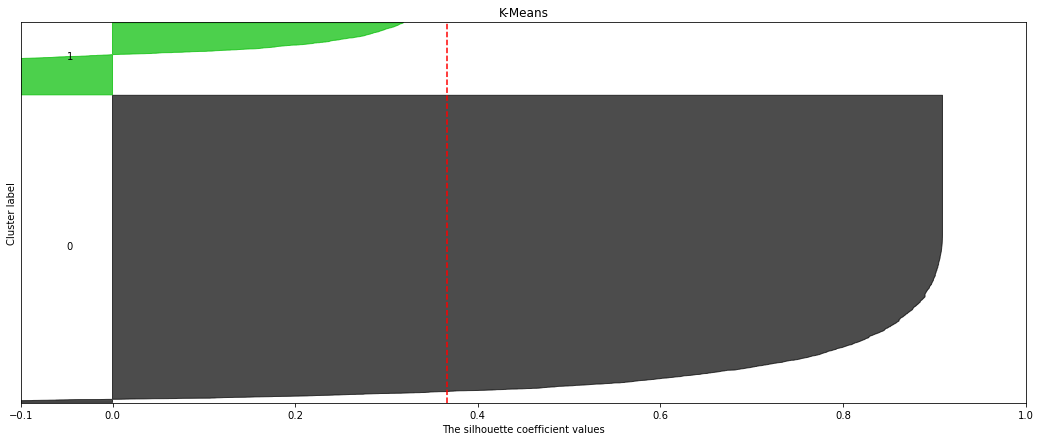

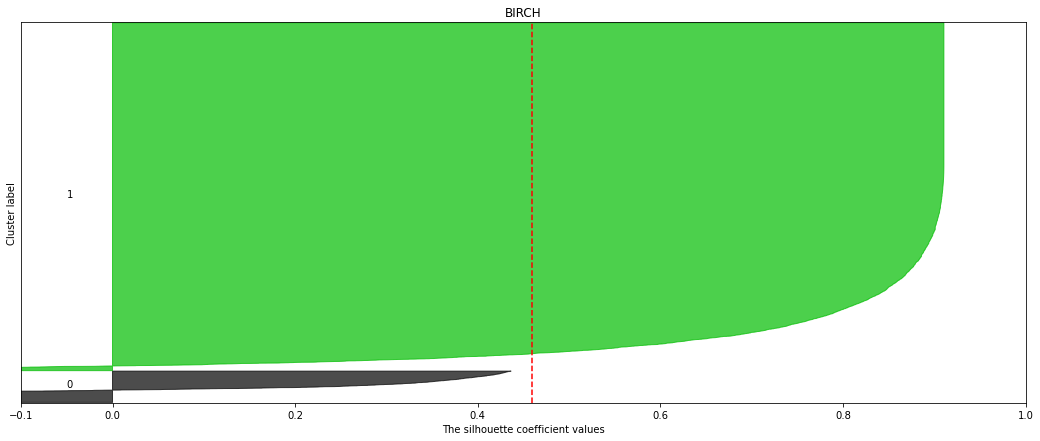

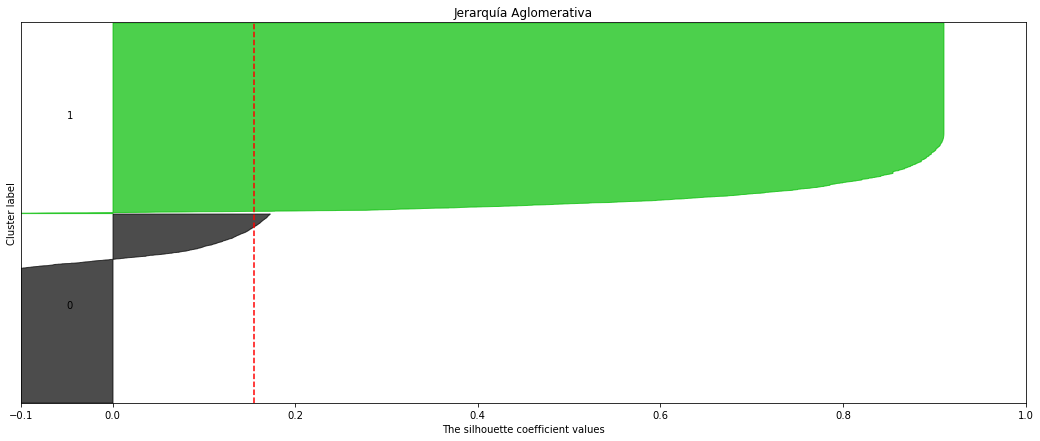

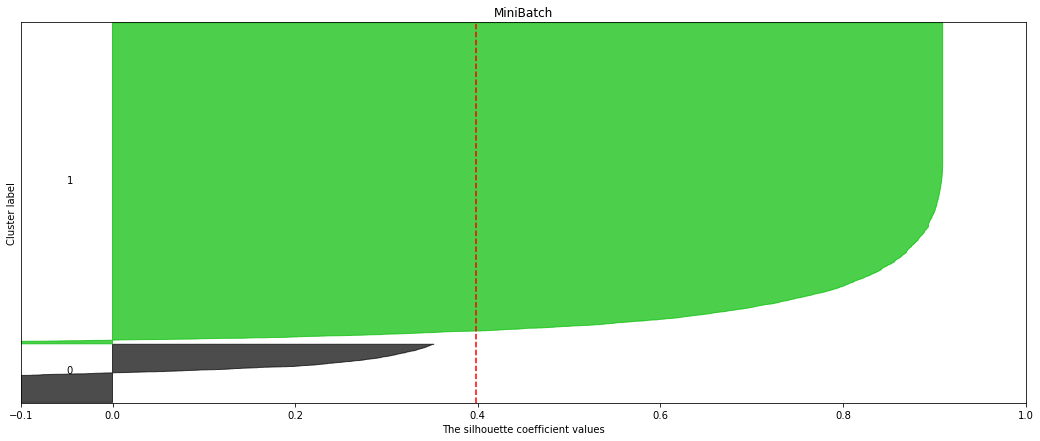

In [65]:
def make_silhouette(clusterer, n_clusters, label):
    fig, ax = plt.subplots(figsize=(1,1))
    fig.set_size_inches(18, 7)

    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X_scale) + (n_clusters + 1) * 10])

    cluster_labels = clusterer.fit_predict(X_scale)

    silhouette_avg = silhouette_score(X_scale, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score of",
        label,
        'is:',
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(variables, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title(label)
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([]) 
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

make_silhouette(kmeans_cluster, number_clusters, 'K-Means')
make_silhouette(birch_model, number_clusters, 'BIRCH')
make_silhouette(agglomerative_model, number_clusters, 'Jerarquía Aglomerativa')
make_silhouette(minibatch_model, number_clusters, 'MiniBatch')
plt.show()